### Data Preparation

In [ ]:
!pip install pyspark==3.2.1
!pip install minio

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import *
import time

spark = SparkSession.builder.appName('demo').getOrCreate()

### Define the schema of the data, if data has more columns just go with the bydefault schema, instaed create your own schema suitable for the data

In [25]:
schema = spark.read.csv('s3_attribution_data.csv_2023_04_18_15_30_25.csv',header=True).schema
schema

StructType(List(StructField(uid,StringType,true),StructField(time,StringType,true),StructField(interaction,StringType,true),StructField(channel,StringType,true),StructField(conversion,StringType,true)))

In [7]:
#convert the csv data to table data, easily accessible through pysql

spark.read.option("header",True) \
          .csv("s3_attribution_data.csv_2023_04_18_15_30_25.csv") \
          .createOrReplaceTempView("attribution")

In [8]:
data.select("uid","time","channel","conversion") \
     .show(5)

+--------------------+-------------------+--------------------+----------+
|                 uid|               time|             channel|conversion|
+--------------------+-------------------+--------------------+----------+
|ec66fa36ab5e42558...|2020-05-22 04:31:17|Search Engine Mar...|         0|
|ec66fa36ab5e42558...|2020-06-07 20:05:15|          Affiliates|         0|
|ec66fa36ab5e42558...|2020-06-09 14:14:47|          Affiliates|         0|
|ec66fa36ab5e42558...|2020-06-09 16:17:36|Search Engine Mar...|         0|
|ba0c1d0c041a4a539...|2020-06-05 01:18:50|Search Engine Mar...|         0|
+--------------------+-------------------+--------------------+----------+
only showing top 5 rows



### Create a User Journey Table

The query below aggregates each users journey into a single row. This includes

- uid: the user identifier for a given user.
- path: the list of channels that impressions for a given campaign have been delivered on to a given user.
- first_interaction: the first channel that an impression for a given campaign was delivered on for a given user.
- last_interaction: the last channel that an impression for a given campaign was delivered on for a given user.
- conversion: boolean indicating whether the given user has converted (1) or not (0).


This query is used to create a temporary view. The temporary view will be used in Step 2.3 to create a table.

In [9]:
spark.sql("""CREATE OR REPLACE TEMP VIEW user_journey_view AS
SELECT
  sub2.uid AS uid,CASE
    WHEN sub2.conversion == 1 then concat('Start > ', sub2.path, ' > Conversion')
    ELSE concat('Start > ', sub2.path, ' > Null')
  END AS path,
  sub2.first_interaction AS first_interaction,
  sub2.last_interaction AS last_interaction,
  sub2.conversion AS conversion,
  sub2.visiting_order AS visiting_order
FROM
  (
    SELECT
      sub.uid AS uid,
      concat_ws(' > ', collect_list(sub.channel)) AS path,
      element_at(collect_list(sub.channel), 1) AS first_interaction,
      element_at(collect_list(sub.channel), -1) AS last_interaction,
      element_at(collect_list(sub.conversion), -1) AS conversion,
      collect_list(sub.visit_order) AS visiting_order
    FROM
      (
        SELECT
          uid,
          channel,
          time,
          conversion,
          dense_rank() OVER (
            PARTITION BY uid
            ORDER BY
              time asc
          ) as visit_order
        FROM
          attribution
      ) AS sub
    GROUP BY
      sub.uid
  ) AS sub2;
  """).show(10)

++
||
++
++



In [11]:
processed_d = spark.sql("select * from user_journey_view")
processed_d.show(5)

+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|                 uid|                path|   first_interaction|    last_interaction|conversion|      visiting_order|
+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|000035d3f4b2447eb...|Start > Affiliate...|          Affiliates|Search Engine Mar...|         0|[1, 2, 3, 4, 5, 6...|
|00015bee850c40639...|Start > Search En...|Search Engine Mar...|      Social Network|         1|     [1, 2, 3, 4, 5]|
|000171e4c4d24342b...|Start > Social Ne...|      Social Network|               Email|         0|[1, 2, 3, 4, 5, 5...|
|00019a6df0324cab8...|Start > Social Ne...|      Social Network|Search Engine Mar...|         1|        [1, 2, 3, 4]|
|0001c6ac7e4f41b5b...|Start > Social Ne...|      Social Network|Google Display Ne...|         0|  [1, 2, 3, 4, 5, 6]|
+--------------------+--------------------+-------------

In [12]:
dumpCSV = processed_d.withColumn("visiting_order", col("visiting_order").cast("string")) \
                .write \
                .csv(path="usr_journey_attrition_data")

In [13]:
#gold user journey databricks

user_att_data = spark.read.format('csv').option('header','true').load('usr_journey_attrition_data/usr_journey_attribution_data.csv')
user_att_data.show()

+--------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+-----------------------+--------------------+---+--------------------+
|0000427e4c974a9e9ca054a6edb661f1|Start > Search Engine Marketing > Social Network > Google Display Network > Social Network > Search Engine Marketing > Email > Null|Search Engine Marketing|               Email|  0|  [1, 2, 3, 4, 5, 6]|
+--------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+-----------------------+--------------------+---+--------------------+
|            00007b54c06247dea...|                                                                                                               Start > Google Di...|   Google Display Ne...|          Affiliates|  0|        [1, 2, 3, 4]|
|            00010c1be74244eba...|                  

In [14]:
from minio import Minio
from sqlalchemy import create_engine

ACCESS_KEY = "DNPD2SAYLBELJ423HCNU"
SECRET_KEY = "zF7F6W93HS8vt+JKen4U17+zhcHiwH47AMuO3ap0"
PUBLIC_BUCKET = "shared-storage"

client = Minio(
    endpoint="minio-server.default.svc.cluster.local:9000",
    access_key=ACCESS_KEY,
    secret_key=SECRET_KEY,
    secure=False,
)

In [15]:
#gold_user_journey

data_file = "/multi_touch_attribution/usr_journey_attribution_data.csv"

client.fput_object(
    PUBLIC_BUCKET,
    data_file,
    'usr_journey_attrition_data/usr_journey_attribution_data.csv'  
)

### Heuristic approach to compare with data-driven

In the table, gold_user_journey, that we just created in the previous step, we captured the values for first_interaction and last_interaction in their own respective columns. With this data now in place, let's take a look at attribution using the heuristic methods **first-touch** and **last-touch**.

In this step, we will:

- Create a temporary view for first-touch and last-touch attribution metrics
- Use the temporary view to create the gold_attribution table
- Use the gold_attribution table to view first touch vs. last touch by channel


After we build our Markov model we will then take a look at how attribution using a data-driven method compares to these heuristic methods.

**Create temporary view for first-touch and last-touch attribution metrics**

In [16]:
spark.sql("""CREATE OR REPLACE TEMP VIEW attribution_view AS
SELECT
  'first_touch' AS attribution_model,
  first_interaction AS channel,
  round(count(*) / (
     SELECT COUNT(*)
     FROM user_journey_view
     WHERE conversion = 1),2) AS attribution_percent
FROM user_journey_view
WHERE conversion = 1
GROUP BY first_interaction
UNION
SELECT
  'last_touch' AS attribution_model,
  last_interaction AS channel,
  round(count(*) /(
      SELECT COUNT(*)
      FROM user_journey_view
      WHERE conversion = 1),2) AS attribution_percent
FROM user_journey_view
WHERE conversion = 1
GROUP BY last_interaction
""")

DataFrame[]

In [18]:
processed_attr_data = spark.sql("select * from attribution_view")

In [19]:
processed_attr_data.show()

+-----------------+--------------------+-------------------+
|attribution_model|             channel|attribution_percent|
+-----------------+--------------------+-------------------+
|      first_touch|               Email|               0.05|
|      first_touch|      Social Network|               0.21|
|      first_touch|Google Display Ne...|               0.15|
|      first_touch|Search Engine Mar...|               0.29|
|      first_touch|          Affiliates|               0.31|
|       last_touch|Search Engine Mar...|                0.2|
|       last_touch|      Social Network|                0.3|
|       last_touch|          Affiliates|               0.39|
|       last_touch|Google Display Ne...|                0.1|
|       last_touch|               Email|               0.01|
+-----------------+--------------------+-------------------+



In [20]:
processed_attr_data.write.option("header",True) \
 .csv("usr_journey_attrition_data/usr_attribution_data.csv")

In [21]:
#gold_attribution

data_file = "/multi_touch_attribution/usr_attribution_data.csv"

client.fput_object(
    PUBLIC_BUCKET,
    data_file,
    'usr_journey_attrition_data/usr_attribution_data.csv/usr_attribution_data.csv'  
)

### Use the usr_attribution table to view first touch vs. last touch by channel

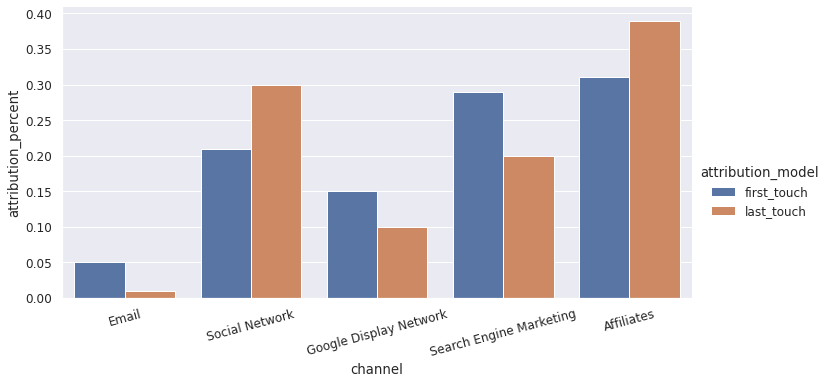

In [23]:
import seaborn as sns
attribution_pd = spark.table('attribution_view').toPandas()
 
sns.set(font_scale=1.1)
sns.catplot(x='channel',y='attribution_percent',hue='attribution_model',data=attribution_pd, kind='bar', aspect=2).set_xticklabels(rotation=15)